In [1]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import cheetah

In [2]:
lattice_file_path = (
    Path("$LCLS_LATTICE") / "bmad" / "models" / "cu_hxr" / "cu_hxr.lat.bmad"
)
lattice_file_path

PosixPath('$LCLS_LATTICE/bmad/models/cu_hxr/cu_hxr.lat.bmad')

In [3]:
lattice_dir = str((Path(".").absolute().parent / "lcls-lattice"))

In [4]:
segment = cheetah.Segment.from_bmad(
    str(lattice_file_path), environment_variables={"LCLS_LATTICE": lattice_dir}
)
segment = segment.flattened()
segment

Segment([Drift(length=-0.87, name="dl00"), Drift(length=0.87, name="loadlock"), Marker(is_active=False, is_skippable=True, name='beggun', device='cpu', length=0), Solenoid(length=0.00, k=0.00, name="sol1bk"), Marker(is_active=False, is_skippable=True, name='dbmark80', device='cpu', length=0), Marker(is_active=False, is_skippable=True, name='cathode', device='cpu', length=0), Drift(length=0.10, name="dl01a"), Solenoid(length=0.20, k=0.00, name="sol1"), Drift(length=0.08, name="dl01a1"), Marker(is_active=False, is_skippable=True, name='vv01', device='cpu', length=0), Drift(length=0.12, name="dl01a2"), Marker(is_active=False, is_skippable=True, name='am00', device='cpu', length=0), Drift(length=0.10, name="dl01a3"), Marker(is_active=False, is_skippable=True, name='am01', device='cpu', length=0), Drift(length=0.02, name="dl01a4"), Marker(is_active=False, is_skippable=True, name='yag01', device='cpu', length=0), Drift(length=0.01, name="dl01a5"), Marker(is_active=False, is_skippable=True, n

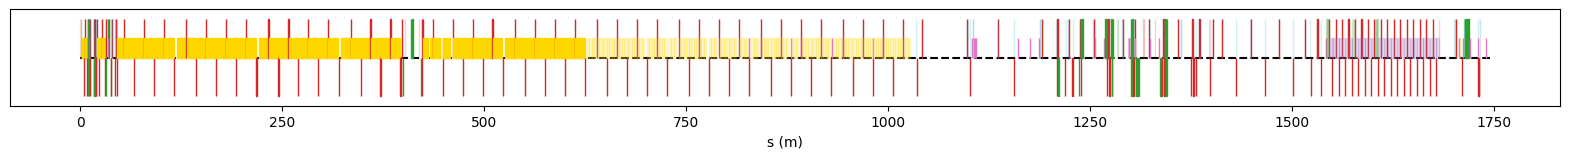

In [5]:
plt.figure(figsize=(20, 1.25))
segment.plot(ax=plt.gca(), s=0.0)

/Users/jankaiser/Documents/DESY/cheetah/cheetah/accelerator.py:1770: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


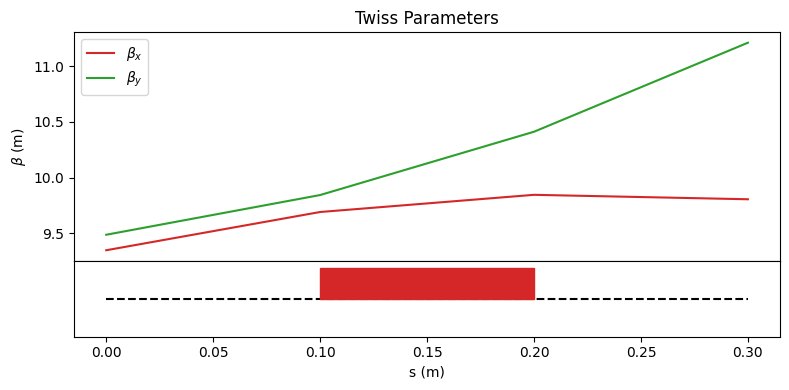

In [6]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=9.34799999999386,
    alpha_x=-1.69459999999829,
    emittance_x=3.494768647122823e-09,
    beta_y=9.48702794424903,
    alpha_y=-1.75970623484325,
    emittance_y=3.497810737006068e-09,
)

mini_segment = cheetah.Segment(
    [
        cheetah.Drift(length=0.1),
        cheetah.Quadrupole(length=0.1, k1=2.0),
        cheetah.Drift(length=0.1),
    ]
)

mini_segment.plot_twiss_over_lattice(beam)

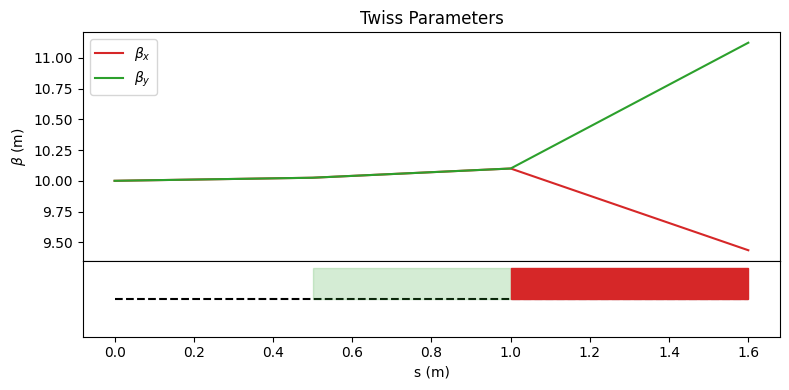

In [7]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=10.0,
    alpha_x=0.0,
    emittance_x=3.494768647122823e-09,
    beta_y=10.0,
    alpha_y=0.0,
    emittance_y=3.497810737006068e-09,
)
segment = cheetah.Segment.from_bmad("test/bmad/bmad_tutorial_lattice.bmad")
segment.plot_twiss_over_lattice(beam)

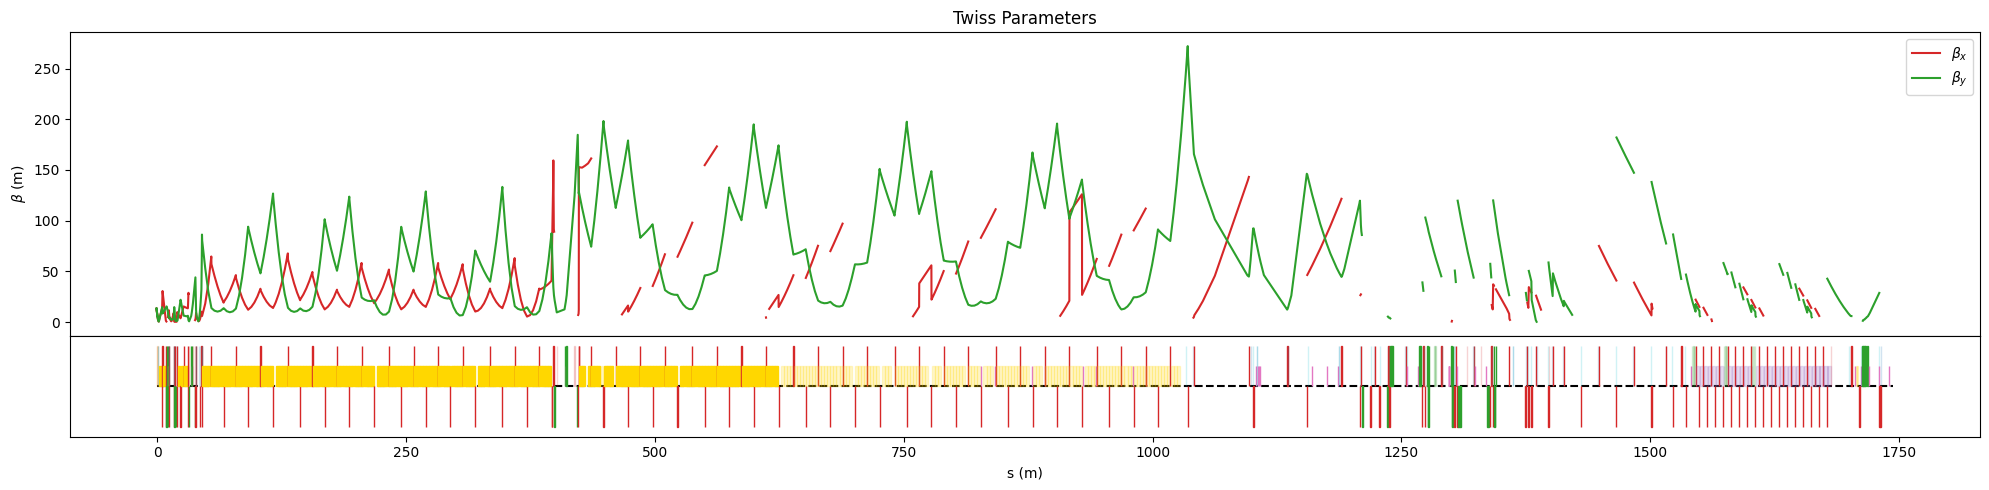

In [8]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=5.91253677,
    alpha_x=3.55631308,
    emittance_x=3.494768647122823e-09,
    beta_y=5.91253677,
    alpha_y=3.55631308,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)

segment = cheetah.Segment.from_bmad(
    str(lattice_file_path), environment_variables={"LCLS_LATTICE": lattice_dir}
)
segment = segment.flattened()

# outgoing = segment.track(beam)

segment.plot_twiss_over_lattice(beam, figsize=(20, 5))

In [9]:
segment

Segment([Drift(length=-0.87, name="dl00"), Drift(length=0.87, name="loadlock"), Marker(is_active=False, is_skippable=True, name='beggun', device='cpu', length=0), Solenoid(length=0.00, k=0.00, name="sol1bk"), Marker(is_active=False, is_skippable=True, name='dbmark80', device='cpu', length=0), Marker(is_active=False, is_skippable=True, name='cathode', device='cpu', length=0), Drift(length=0.10, name="dl01a"), Solenoid(length=0.20, k=0.00, name="sol1"), Drift(length=0.08, name="dl01a1"), Marker(is_active=False, is_skippable=True, name='vv01', device='cpu', length=0), Drift(length=0.12, name="dl01a2"), Marker(is_active=False, is_skippable=True, name='am00', device='cpu', length=0), Drift(length=0.10, name="dl01a3"), Marker(is_active=False, is_skippable=True, name='am01', device='cpu', length=0), Drift(length=0.02, name="dl01a4"), Marker(is_active=False, is_skippable=True, name='yag01', device='cpu', length=0), Drift(length=0.01, name="dl01a5"), Marker(is_active=False, is_skippable=True, n

In [10]:
print(f"{beam.beta_x = }")
print(f"{beam.beta_y = }")

beam.beta_x = tensor(5.9125)
beam.beta_y = tensor(5.9125)


In [11]:
beam_stepped = beam
for element in segment.elements[:39]:
    beam_stepped = element.track(beam_stepped)

print(f"{element.name = }")
print(f"{beam_stepped.beta_x = }")
print(f"{beam_stepped.beta_y = }")
print(f"{beam_stepped.alpha_x = }")
print(f"{beam_stepped.alpha_y = }")

element.name = 'l0a'
beam_stepped.beta_x = tensor(12.8568)
beam_stepped.beta_y = tensor(12.8568)
beam_stepped.alpha_x = tensor(-3.5249)
beam_stepped.alpha_y = tensor(-3.5249)


In [12]:
segment.l0a

Cavity(is_active=True, is_skippable=False, name='l0a', device='cpu', length=3.095244, voltage=58010690.667105, phase=-1.0999999999999999, frequency=2856000000.0)

In [19]:
incoming_beam = cheetah.ParticleBeam.from_twiss(
    num_particles=1_000_000,
    beta_x=0.44865302,
    beta_y=0.44865302,
    alpha_x=0.18863809,
    alpha_y=0.18863809,
    emittance_x=3.494768647122823e-09,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)
# cavity_element = cheetah.Cavity(
#     length=3.0952440, voltage=5.8010691e7, phase=-3.0555556e-3, frequency=2.8560000e9
# )
cavity_element = cheetah.Cavity(
    length=3.0952440,
    voltage=5.8010691e7,
    phase=np.degrees(-3.0555556e-3 * 2 * np.pi),
    frequency=2.8560000e9,
)

outgoing_beam = cavity_element.track(incoming_beam)

print(f"{outgoing_beam.beta_x = }")
print(f"{outgoing_beam.beta_y = }")
print(f"{outgoing_beam.alpha_x = }")
print(f"{outgoing_beam.alpha_y = }")
print(f"{outgoing_beam.energy = }")

outgoing_beam

outgoing_beam.beta_x = tensor(12.8575)
outgoing_beam.beta_y = tensor(12.8490)
outgoing_beam.alpha_x = tensor(-3.5258)
outgoing_beam.alpha_y = tensor(-3.5226)
outgoing_beam.energy = tensor(64000000.3325, dtype=torch.float64)


ParticleBeam(n=1000000, mu_x=-0.000000, mu_xp=-0.000000, mu_y=-0.000000, mu_yp=-0.000000, sigma_x=0.000065, sigma_xp=0.000018, sigma_y=0.000065, sigma_yp=0.000019, sigma_s=0.000000, sigma_p=0.000001, energy=64000000.333)

In [18]:
print(f"{cavity_element.length = } m")
print(f"{cavity_element.voltage = } V")
print(f"{cavity_element.phase = } deg")
print(f"{cavity_element.frequency = } Hz")

cavity_element.length = 3.095244 m
cavity_element.voltage = 58010691.0 V
cavity_element.phase = -1.1000000159999999 deg
cavity_element.frequency = 2856000000.0 Hz


In [21]:
import ocelot

In [23]:
tws = ocelot.Twiss()
tws.beta_x = 0.44865302
tws.beta_y = 0.44865302
tws.alpha_x = 0.18863809
tws.alpha_y = 0.18863809
tws.emit_x = 3.494768647122823e-09
tws.emit_y = 3.497810737006068e-09
tws.gamma_x = (1 + tws.alpha_x**2) / tws.beta_x
tws.gamma_y = (1 + tws.alpha_y**2) / tws.beta_y
tws.E = 6e-3

p_array = ocelot.generate_parray(tws=tws)

cell = [
    ocelot.Cavity(
        l=3.0952440,
        v=5.8010691e7 * 1e-9,
        freq=2.8560000e9,
        phi=np.degrees(-3.0555556e-3 * 2 * np.pi),
    )
]
lattice = ocelot.MagneticLattice(cell)
navigator = ocelot.Navigator(lattice=lattice)

_, outgoing_parray = ocelot.track(lattice, deepcopy(p_array), navigator)
derived_twiss = ocelot.cpbd.beam.get_envelope(outgoing_parray)

print(derived_twiss)

[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


z = 3.095244 / 3.095244. Applied: emit_x  = 3.2688336805880204e-10
emit_y  = 3.284914343857117e-10
beta_x  = 12.856815106445865
beta_y  = 12.856815106442994
alpha_x = -3.524868604372471
alpha_y = -3.5248686043537316
gamma_x = 1.0441698482044868
gamma_y = 1.0441698481944446
Dx      = 0.0
Dy      = 0.0
Dxp     = 0.0
Dyp     = 0.0
mux     = 0.0
muy     = 0.0
nu_x    = 0.0
nu_y    = 0.0
E       = 0.06400000033252268
s        = 0.0

